# Kaggle Microsoft Malware competition 2019(Currently Inactive):

### Link : https://www.kaggle.com/c/microsoft-malware-prediction

### Problem Overview: Microsoft is challenging the data science community to develop techniques to predict if a machine will soon be hit with malware. They have provided 82 feature columns, and 8.7 million rows based on which previous detection rates have been measured. The end goal is to come up with a model for predicting malware occurrences in the future.

## Various Required Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
import datetime
from sklearn import metrics
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
# Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)

### Utility function (learned from a kaggle kernel for  reducing memory usage by converting data types of features )


In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Function for enabling Plotly notebook mode with google colaboratory

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
"""configure_plotly_browser_state() can be executed before running every cell by using IPython's pre_run_cell hook"""

import IPython

IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

### Defining data types for large datasets is highly recommended for reducing memory usage! (learned from a kaggle kernel)

In [0]:
datatypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16'
        }

# Get the files and select the variables
### Following a Kaggle kernel, we set the types of each fields in the train set and test set in order to reduce the memory usage:

In [0]:
data = pd.read_csv('/content/kaggle/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"',dtype=datatypes,nrows=5000000)

In [0]:
train_data = data.copy()

In [9]:
train_data = reduce_mem_usage(train_data)

Mem. usage decreased to 918.62 Mb (3.5% reduction)


In [0]:
test = pd.read_csv('/content/kaggle/test.csv.zip', compression='zip', header=0, sep=',', quotechar='"',dtype=datatypes,nrows=5000000)

In [0]:
test_data = test.copy()

In [12]:
test_data = reduce_mem_usage(test_data)

Mem. usage decreased to 913.86 Mb (0.0% reduction)


### Next , we will be removing features from our data sets based on EDA steps we have performed in our ""microsoft_malware_EDA.ipynb"" notebook

In [0]:
remove_cols = ['Census_ProcessorClass',
 'Census_IsWIMBootEnabled',
 'IsBeta',
 'Census_IsFlightsDisabled',
 'Census_IsFlightingInternal',
 'AutoSampleOptIn',
 'Census_ThresholdOptIn',
 'SMode',
 'Census_IsPortableOperatingSystem',
 'PuaMode',
 'Census_DeviceFamily',
 'UacLuaenable',
 'Census_IsVirtualDevice',
 'Platform',
 'Census_OSSkuName',
 'Census_OSInstallLanguageIdentifier',
 'Processor']

In [0]:
train_new = train_data.drop(remove_cols,axis=1)

In [0]:
test_new = test_data.drop(remove_cols,axis=1)

In [16]:
train_new.shape,test_new.shape

((5000000, 66), (5000000, 65))

# Frequency encoding
#### For variables with large cardinality, an efficient encoding consists in ranking the categories with respect to their frequencies. These variables are then treated as numerical.

In [0]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]
binary_variables = [c for c in train_new.columns if train_new[c].nunique() == 2]
categorical_columns = [c for c in train_new.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [19]:
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, train_new[c].nunique()])

cardinality.sort(key = lambda x:x[1], reverse=False)
# print(cardinality)

trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train_new')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


### Defining a function for performing frequency encoding based on cardinality

In [20]:
def frequency_encoding(variable):
    t = pd.concat([train_new[variable], test_new[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [21]:
""" List of columns having high cardinality """
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'AVProductStatesIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'DefaultBrowsersIdentifier'
]

In [22]:
for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable)
    train_new[variable] = train_new[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    test_new[variable] = test_new[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    categorical_columns.remove(variable)

100%|██████████| 8/8 [00:36<00:00,  4.28s/it]


## Label Encoding of Categoricals

In [23]:
indexer = {}
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(train_new[col])
    
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    train_new[col] = indexer[col].get_indexer(train_new[col])
    test_new[col] = indexer[col].get_indexer(test_new[col])

100%|██████████| 39/39 [07:37<00:00,  9.20s/it]


In [24]:
train_new = reduce_mem_usage(train_new)
test_new = reduce_mem_usage(test_new)

Mem. usage decreased to 722.67 Mb (66.5% reduction)
Mem. usage decreased to 717.90 Mb (66.7% reduction)


#### Pickling the processed data so far

In [25]:
train_new.to_pickle('train_engineered.pickle')
test_new.to_pickle('test_engineered.pickle')

# Training the LGBM model

### Parameters for Hyper-Parameter Tuning

In [0]:
param = {'num_leaves': 60,
          'min_data_in_leaf': 60, 
          'objective':'binary',
          'max_depth': 8,
          'learning_rate': 0.1,
          'boosting': 'gbdt',
          'feature_fraction': 0.8,
          'bagging_freq': 1,
          'bagging_fraction': 0.8 ,
          'bagging_seed': 11,
          'metric': 'auc',
          'lambda_l1': 0.50,
          'random_state': 42,
          'njobs':-1,
          'verbosity': -1}

#### Reading the pickled files and using a sub sample of data(due to low memory) for Training and Predicting

In [0]:
train_1 = pd.read_pickle(r'C:\Users\sachin.mandhotra\Sachin_work\ML_practice\microsoft_malware\train_engineered.pickle')
test_1 = pd.read_pickle(r'C:\Users\sachin.mandhotra\Sachin_work\ML_practice\microsoft_malware\test_engineered.pickle')
train_1 = train_1.iloc[:2500000,:]
test_1 = test_1.iloc[:2500000,:]

In [0]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]
binary_variables = [c for c in train_1.columns if train_1[c].nunique() == 2]
categorical_columns = [c for c in train_1.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [5]:
target = train_1['HasDetections']
train_1.drop('HasDetections',axis=1,inplace=True)
train_1.shape,test_1.shape,target.shape

((2500000, 65), (2500000, 65), (2500000,))

## Performing K-Fold cross Validation (5 splits)

In [6]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)
features = [c for c in train_1.columns] #features
predictions = np.zeros(len(test_1))
score = [0 for _ in range(folds.n_splits)] #5 scores for 5 different rmse!
roc_l = []
roc_mean = []
for fold_, (trn_id, val_id) in enumerate(folds.split(train_1.values, target.values)):
    print("fold n°{}".format(fold_))
    X_train = train_1.iloc[trn_id][features]
    X_valid = train_1.iloc[val_id][features]
    y_train = target.iloc[trn_id]
    y_valid = target.iloc[val_id]
    
    
    
    trn_data = lgb.Dataset(X_train,
                           label=y_train,
                           categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(X_valid,
                           label=y_valid,
                           reference=trn_data,
                           categorical_feature = categorical_columns
                          )

    num_round = 10000
    model = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200
                   )
    #To fine tune the model
    pred_test_y = model.predict(X_valid, num_iteration=model.best_iteration)
    #For final predictions
    pred_test = model.predict(test_1, num_iteration=model.best_iteration)
    predictions += pred_test/5
    
    
    #Printing the mean of rmse after, 5 fold validation
    roc = roc_auc_score(y_valid, pred_test_y)
    roc_l.append(roc)
    
roc_array = np.asarray(roc_l)
    
roc_mean.append(roc_array.mean())

print('Mean roc value: '+str(roc_mean[0]))

fold n°0


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's auc: 0.749165	valid_1's auc: 0.717742
fold n°1


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[175]	training's auc: 0.743342	valid_1's auc: 0.718077
fold n°2


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[174]	training's auc: 0.742162	valid_1's auc: 0.716653
fold n°3


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[167]	training's auc: 0.743611	valid_1's auc: 0.717942
fold n°4


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[248]	training's auc: 0.748386	valid_1's auc: 0.716299
Mean roc value: 0.7173423866824231


# Feature Importance

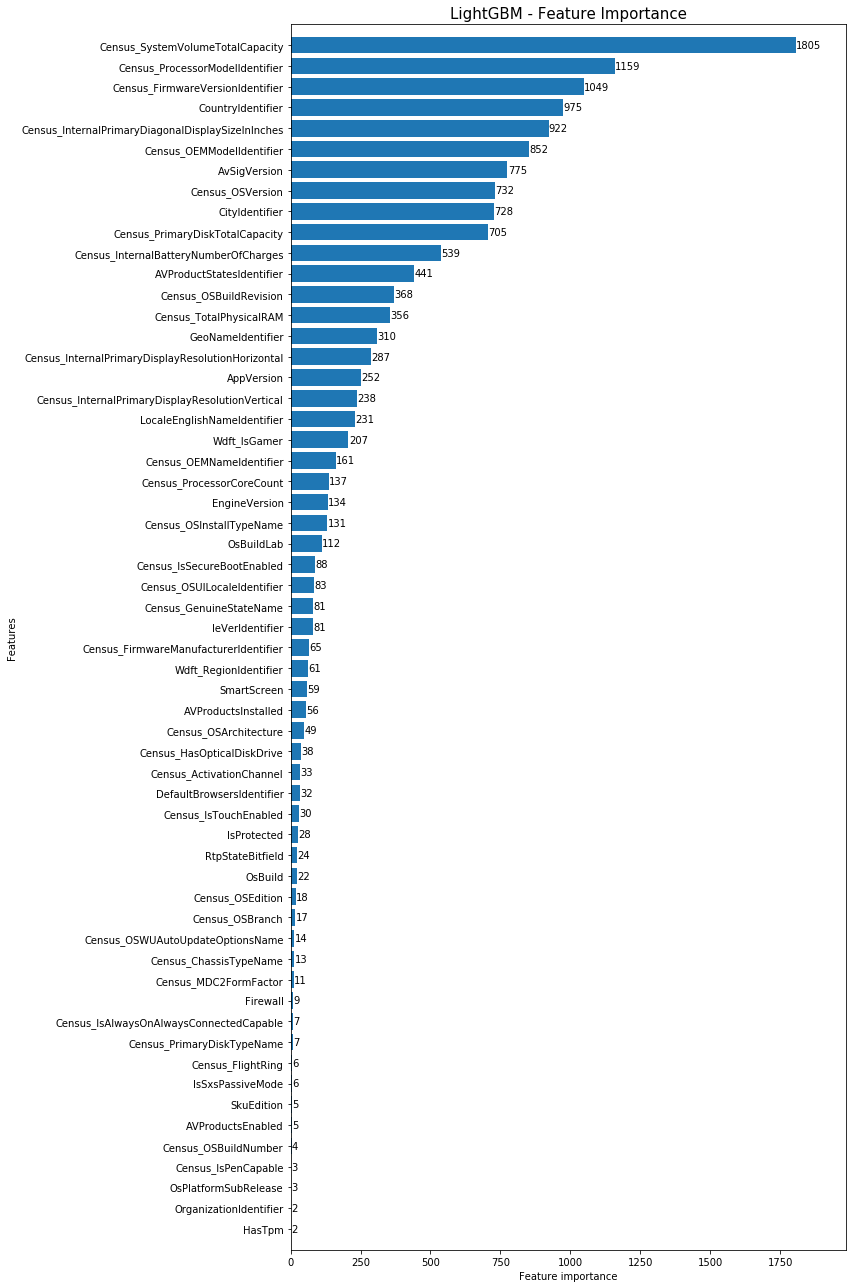

In [7]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=65, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.tight_layout()
# plt.savefig('lgbm_1st4mil_importances.png')
plt.show()

# To conclude this project here :
## We achieved validation roc auc accuracy of 71% after removing Features which are not useful to our model abd Frequency-Encoding Categorical Variables with high cardinality  & using LightGradientBoostingModel(LGBM).